# PR Response Time Analysis (Business Days)

Learn whether your community is responding to pull requests within
a reasonable timeframe by comparing response times to a number of business
days threshold / expectation that you set.

------------
All the notebooks in this folder are based on https://github.com/chaoss/augur-community-reports templates. 

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import warnings
import datetime
from pandas.tseries.offsets import BusinessDay
from matplotlib.ticker import MaxNLocator
from dateutil.relativedelta import relativedelta

warnings.filterwarnings('ignore')

with open("../../config_temp.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Control Cell - Set Variables and Filters

The cell below is for generating repo_ids from the repo names. For this to work, the repo must already be in the database. If you want to manually assign a repo_id skip the cell below and read the comments on the next cell.

In [2]:
#add your repo name here of the repo you want to query if known (and in the database)
repo_name = 'augur'

repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT 
                b.repo_id
            FROM
                repo_groups a,
                repo b
            WHERE
                a.repo_group_id = b.repo_group_id AND
                b.repo_name = \'{repo_name}\'
    """)

t = engine.execute(repo_query)
repo_id =t.mappings().all()[0].get('repo_id')
print(repo_id)

25440


In [3]:
#Take this out of quotes if you want to manually assign a repo_id number
repo_id = 25440

# Provide number of business days threshold. This is the number of business days
# within which you expect people to respond to PRs. Default is 2 business days.
bus_days = 2

#specify dates for filtering - a typical default would be one year of data
#if the end_date is in the future, the end_date will default to the current_date
begin_date = '2020-02-01'
end_date = '2021-01-31'

## Gathering and Processing the Data

### Getting the data from your Augur database

In [4]:
pr_all = pd.DataFrame()

pr_query = salc.sql.text(f"""
                 SELECT
                    repo.repo_id AS repo_id,
                    pull_requests.pr_src_id AS pr_src_id,
                    repo.repo_name AS repo_name,
                    pr_src_author_association,
                    repo_groups.rg_name AS repo_group,
                    pull_requests.pr_src_state,
                    pull_requests.pr_merged_at,
                    pull_requests.pr_created_at AS pr_created_at,
                    pull_requests.pr_closed_at AS pr_closed_at,
                    date_part( 'year', pr_created_at :: DATE ) AS CREATED_YEAR,
                    date_part( 'month', pr_created_at :: DATE ) AS CREATED_MONTH,
                    date_part( 'year', pr_closed_at :: DATE ) AS CLOSED_YEAR,
                    date_part( 'month', pr_closed_at :: DATE ) AS CLOSED_MONTH,
                    pr_src_meta_label,
                    pr_head_or_base,
                    ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_close,
                    ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_close, 
                    ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_first_response,
                    ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_first_response, 
                    ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_last_response,
                    ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_last_response, 
                    first_response_time,
                    last_response_time,
                    average_time_between_responses,
                    assigned_count,
                    review_requested_count,
                    labeled_count,
                    subscribed_count,
                    mentioned_count,
                    referenced_count,
                    closed_count,
                    head_ref_force_pushed_count,
                    merged_count,
                    milestoned_count,
                    unlabeled_count,
                    head_ref_deleted_count,
                    comment_count,
                    lines_added, 
                    lines_removed,
                    commit_count, 
                    file_count
                FROM
                repo,
                repo_groups,
                pull_requests LEFT OUTER JOIN ( 
                        SELECT pull_requests.pull_request_id,
                            MIN(message.msg_timestamp) AS first_response_time,
                            COUNT(DISTINCT message.msg_timestamp) AS comment_count,
                            MAX(message.msg_timestamp) AS last_response_time,
                            (MAX(message.msg_timestamp) - MIN(message.msg_timestamp)) / COUNT(DISTINCT message.msg_timestamp) AS average_time_between_responses
                        FROM repo, 
                            pull_requests left outer join pull_request_message_ref 
                            on pull_requests.pull_request_id = pull_request_message_ref.pull_request_id
                            left outer join message on pull_request_message_ref.msg_id = message.msg_id and cntrb_id not in (select cntrb_id from contributors where cntrb_login like '%[bot]')
                        WHERE repo.repo_id = {repo_id}
                        AND repo.repo_id = pull_requests.repo_id
                        GROUP BY pull_requests.pull_request_id
                ) response_times
                ON pull_requests.pull_request_id = response_times.pull_request_id
                left outer join (
                        SELECT pull_requests.pull_request_id,
                            count(*) FILTER (WHERE action = 'assigned') AS assigned_count,
                            count(*) FILTER (WHERE action = 'review_requested') AS review_requested_count,
                            count(*) FILTER (WHERE action = 'labeled') AS labeled_count,
                            count(*) FILTER (WHERE action = 'unlabeled') AS unlabeled_count,
                            count(*) FILTER (WHERE action = 'subscribed') AS subscribed_count,
                            count(*) FILTER (WHERE action = 'mentioned') AS mentioned_count,
                            count(*) FILTER (WHERE action = 'referenced') AS referenced_count,
                            count(*) FILTER (WHERE action = 'closed') AS closed_count,
                            count(*) FILTER (WHERE action = 'head_ref_force_pushed') AS head_ref_force_pushed_count,
                            count(*) FILTER (WHERE action = 'head_ref_deleted') AS head_ref_deleted_count,
                            count(*) FILTER (WHERE action = 'milestoned') AS milestoned_count,
                            count(*) FILTER (WHERE action = 'merged') AS merged_count
                        from repo, pull_requests left outer join pull_request_events 
                            on pull_requests.pull_request_id = pull_request_events.pull_request_id
                        WHERE repo.repo_id = {repo_id}
                            AND repo.repo_id = pull_requests.repo_id
                        GROUP BY pull_requests.pull_request_id
                ) event_counts on event_counts.pull_request_id = pull_requests.pull_request_id
                LEFT OUTER JOIN (
                        SELECT pull_request_commits.pull_request_id, count(DISTINCT pr_cmt_sha) AS commit_count                                FROM pull_request_commits, pull_requests, pull_request_meta
                        WHERE pull_requests.pull_request_id = pull_request_commits.pull_request_id
                        AND pull_requests.pull_request_id = pull_request_meta.pull_request_id
                        AND pull_requests.repo_id = {repo_id}
                        AND pr_cmt_sha <> pull_requests.pr_merge_commit_sha
                        AND pr_cmt_sha <> pull_request_meta.pr_sha
                        GROUP BY pull_request_commits.pull_request_id
                ) all_commit_counts
                ON pull_requests.pull_request_id = all_commit_counts.pull_request_id
                LEFT OUTER JOIN (
                        SELECT MAX(pr_repo_meta_id), pull_request_meta.pull_request_id, pr_head_or_base, pr_src_meta_label
                        FROM pull_requests, pull_request_meta
                        WHERE pull_requests.pull_request_id = pull_request_meta.pull_request_id
                        AND pull_requests.repo_id = {repo_id}
                        AND pr_head_or_base = 'base'
                        GROUP BY pull_request_meta.pull_request_id, pr_head_or_base, pr_src_meta_label
                ) base_labels
                ON base_labels.pull_request_id = pull_requests.pull_request_id
                LEFT OUTER JOIN (
                        SELECT sum(cmt_added) AS lines_added, sum(cmt_removed) AS lines_removed, pull_request_commits.pull_request_id, count(DISTINCT cmt_filename) AS file_count
                        FROM pull_request_commits, commits, pull_requests, pull_request_meta
                        WHERE cmt_commit_hash = pr_cmt_sha
                        AND pull_requests.pull_request_id = pull_request_commits.pull_request_id
                        AND pull_requests.pull_request_id = pull_request_meta.pull_request_id
                        AND pull_requests.repo_id = {repo_id}
                        AND commits.repo_id = pull_requests.repo_id
                        AND commits.cmt_commit_hash <> pull_requests.pr_merge_commit_sha
                        AND commits.cmt_commit_hash <> pull_request_meta.pr_sha
                        GROUP BY pull_request_commits.pull_request_id
                ) master_merged_counts 
                ON pull_requests.pull_request_id = master_merged_counts.pull_request_id                   
                WHERE 
                    repo.repo_group_id = repo_groups.repo_group_id 
                    AND repo.repo_id = pull_requests.repo_id 
                    AND repo.repo_id = {repo_id}
                    AND pr_created_at >= '{begin_date}'
                    AND pr_created_at <= '{end_date}'
                ORDER BY
                   merged_count DESC
                   """)
pr_a = pd.read_sql(pr_query, con=engine)
if not pr_all.empty: 
    pr_all = pd.concat([pr_all, pr_a]) 
else: 
    # first repo
    pr_all = pr_a

get_repo_name_query = f"""
    SELECT repo_name from repo where repo_id = {repo_id};
       """
get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
repo_name = get_repo_name.repo_name[0]


### Setting up the Dataframe

In [5]:
bd = pd.tseries.offsets.BusinessDay(n = bus_days) 

pr_all['diff'] = pr_all.first_response_time - pr_all.pr_created_at
pr_all['bus_days'] = pr_all.pr_created_at + bd
pr_all['yearmonth'] = pr_all['pr_created_at'].dt.strftime('%Y-%m')

pr_all['in_guidelines'] = np.where(pr_all['bus_days'] < pr_all['first_response_time'], 0, 1)

year_month_list = pr_all.yearmonth.unique()
year_month_list.sort()
first_response = pr_all.groupby(['repo_name', 'yearmonth'], as_index=False).sum()[['repo_name', 'yearmonth', 'in_guidelines']]

# counts total number of PRs each month
total_by_month = pr_all.groupby(['repo_name', 'yearmonth'], as_index=False).count()[['repo_name', 'yearmonth', 'pr_created_at']]

first_response['total_prs'] = total_by_month['pr_created_at']
first_response['out_percent'] = first_response['total_prs'] - first_response['in_guidelines']
first_response['in_percent'] = first_response['in_guidelines'] / first_response['total_prs']

**Calculating Whether Responses are within Business Days Threshold and Adding Analysis to Title**

In [6]:
risk_num = 0
six_months = str(datetime.date.today() + relativedelta(months=-7))
for item in first_response.iterrows():
    year_month = item[1]['yearmonth']
    percent = item[1]['out_percent']
    if (percent > 0.10 and year_month >= six_months):
        risk_num+=1

title = repo_name.capitalize() + "\nTimely Responses:"

if risk_num >= bus_days:
    title += " AT RISK\n" + str(risk_num) + " month(s) with > 10% of pull requests not responded to within " + str(bus_days) + " business days in the past 6 months."
    title_color = 'firebrick'
else:
    title += " Healthy\nMore than 90% of pull requests responded to within " + str(bus_days) + " business days for " + str(6 - risk_num) + " out of the past 6 months."
    title_color = 'forestgreen'

## Plotting the Results

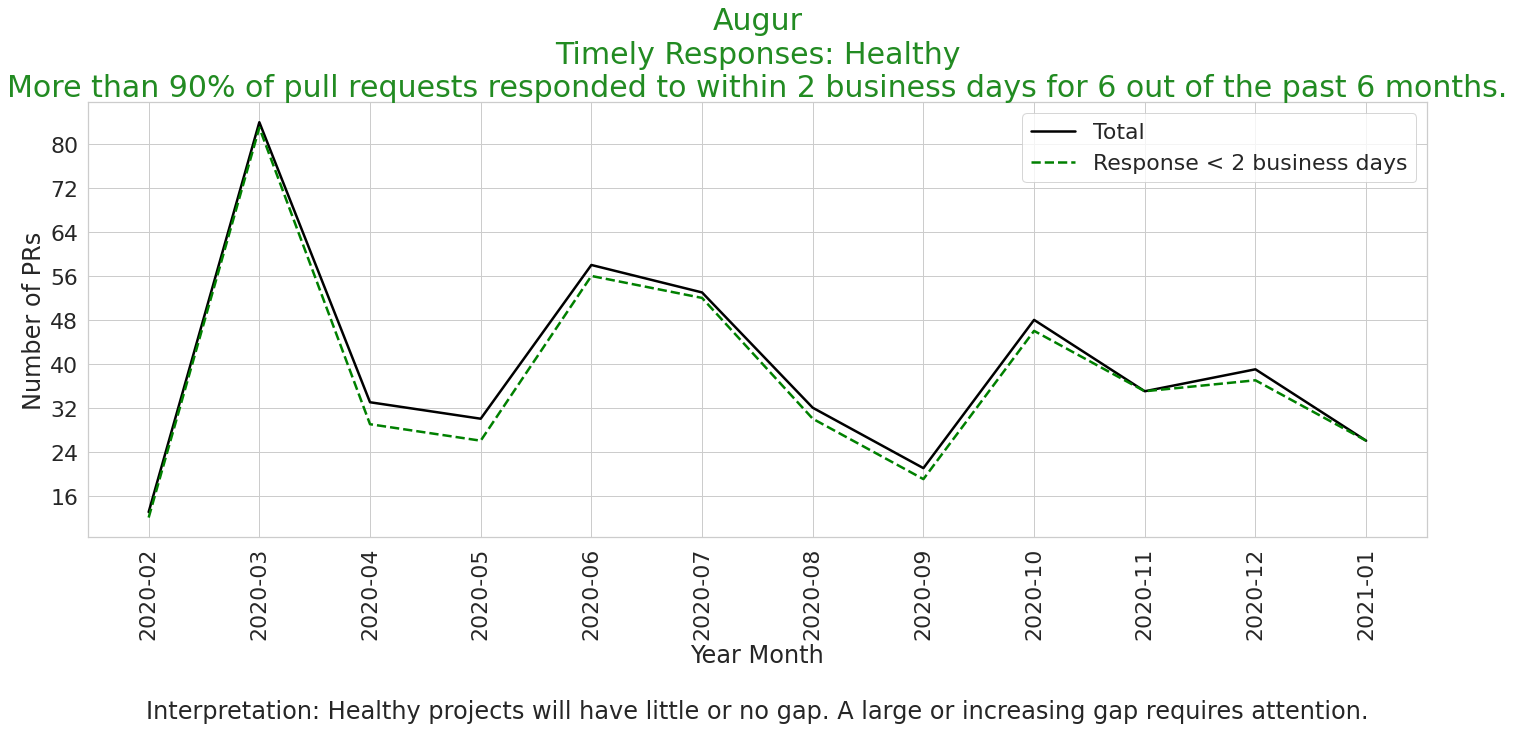

In [7]:
sns.set_style('ticks')
sns.set(style="whitegrid", font_scale=2)

fig, ax = plt.subplots()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# the size of A4 paper
fig.set_size_inches(24, 8)

bus_label = "Response < " + str(bus_days) + " business days"
    
plottermonth = sns.lineplot(x='yearmonth', y='total_prs', data=first_response, sort=False, color='black', label='Total', linewidth=2.5)
plottermonth = sns.lineplot(x='yearmonth', y='in_guidelines', data=first_response, sort=False, color='green', label=bus_label, linewidth=2.5, linestyle='dashed').set_title(title, fontsize=30, color=title_color) 

plottermonthlabels = ax.set_xticklabels(first_response['yearmonth'], rotation=90)
plottermonthlabels = ax.set_ylabel('Number of PRs')
plottermonthlabels = ax.set_xlabel('Year Month\n\nInterpretation: Healthy projects will have little or no gap. A large or increasing gap requires attention.')

### Optional step if you would like to save the figure

In [8]:
fig.savefig('outputs/bus_days.png', bbox_inches='tight')